## **분류 연습 문제**
___
출처 : 핸즈온 머신러닝 Ch03 분류 연습문제 1, 2번

In [ ]:
# import data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)

In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요.**
___

1. `KNeghtborsClassifier`를 사용하는 것을 추천합니다.
2. `weights`와 `n_neighbors` 하이퍼 파라미터로 그리드 탐색을 시도하여, 좋은 하이퍼 파라미터 값을 찾아보세요.

In [ ]:
# import package
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
# Try GridSearch to optimize hyperparameter

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [32]:
# best hyperparameter
best_params = grid_search.best_params_

In [33]:
# best score
best_params = grid_search.best_score_

In [34]:
# model test
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9717

### **2. 다음 단계를 따라 인위적으로 훈련 세트를 늘리는 데이터 증식 또는 훈련 세트 확장 기법을 연습해봅시다.**
___

#### **STEP 1. MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어 보세요.**

In [ ]:
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import numpy as np

<ipython-input-23-35609f150c8c>:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

####  **STEP 2. 앞에서 만든 함수를 이용하여, 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가하세요**

In [35]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

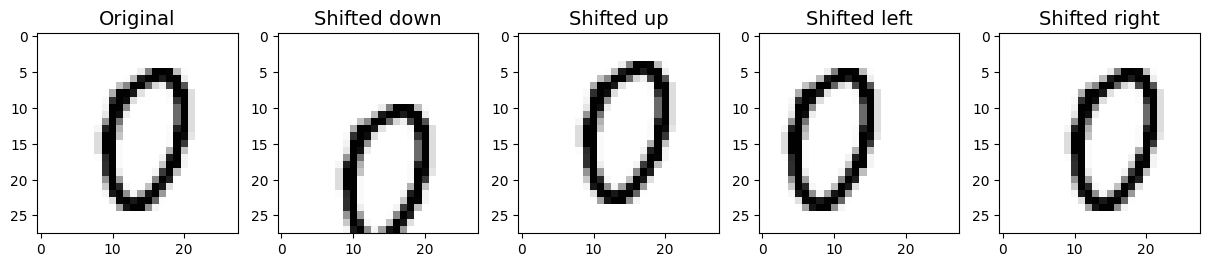

In [36]:
plt.figure(figsize=(15,3))

# 원본 이미지
plt.subplot(1, 5, 1)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

# 아래쪽으로 이동한 이미지
plt.subplot(1, 5, 2)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

# 위쪽으로 이동한 이미지
shifted_image_up = shift_image(image, 0, -1)
plt.subplot(1, 5, 3)
plt.title("Shifted up", fontsize=14)
plt.imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")

# 왼쪽으로 이동한 이미지
plt.subplot(1, 5, 4)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

# 오른쪽으로 이동한 이미지
shifted_image_right = shift_image(image, 1, 0)
plt.subplot(1, 5, 5)
plt.title("Shifted right", fontsize=14)
plt.imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()


In [37]:
# 훈련 데이터를 오른쪽, 왼쪽, 위, 아래로 이동(shift)하여 증강하고, 이를 NumPy 배열로 변환하여 모델 학습에 활용할 수 있도록 준비
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [38]:
# 데이터 순서를 랜덤하게 섞어 모델이 특정 순서에 의존하지 않도록 함-> 훈련 과정에서 더 일반화된 학습이 가능하도록 유도
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

####  **STEP 3. 위에서 확장한 데이터셋을 이용하여, 1번 문제에서 찾은 최적 모델을 훈련시키고, 테스트 세트에서 정확도를 측정해보세요**

In [41]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [42]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [43]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763